In [1]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline 

from operator import itemgetter 
from collections import defaultdict
from itertools import combinations

import re
import numpy as np

In [2]:
#List of twitter keywords
Twitter_Keywords = 'e-cig,ecig,e-cigs,ecigs,e-cigarette,ecigarette,e-cigarettes,ecigarettes,vape,vaper,vaping,vapes,vapers,nicotine,tobacco,cigarette,cigarettes,cigar,atomizer,atomizers,cartomizer,cartomizers,ehookah,e-hookah,ejuice,ejuices,e-juice,e-juices,eliquid,eliquids,e-liquid,e-liquids,blu,njoy,green smoke,south beach smoke,eversmoke,joye 510,joye510,joyetech,lavatube,lavatubes,logicecig,logicecigs,smartsmoker,smokestiks,v2 cig,v2 cigs,v2cigs,v2cig,mistic,21st century smoke,logic black label,finiti,nicotek,cigirex,logic platinum,cigalectric,xhale o2,cig2o,green smart living,krave,secondhand vape,secondhand vaping,second-hand vape,second-hand vaping,vape smoke,ecig smoke,e-cig smoke,e-cigarette smoke,vape shs,ecig shs,vape secondhand smoke,vape second-hand smoke,esmoke,e-smoke,stillblowingsmoke,still blowing smoke,notblowingsmoke,not blowing smoke,capublichealth,tobaccofreekids,notareplacement,trulyfree,truly free,sb140,sb 140,sb24,sb 24,cherry tip cigarillos,mini-cigarillos,tip cigarillos,king edward cigars,royal gold cigars,sweet coronella,swisher blk,swisher sweets,vapercon,vapercon west,grimmgreen,vapor,electronic cigarette,vape meet,EcigsSaveLive,EcigsSaveLives,EcigsSavesLives'

In [3]:
#Cleaning the tweets
def cleanTweet(t):
    tweet_text = ''

    if hasattr(t, 'text'): tweet_text = t.text.lower() # to work with tweets objects
    else: tweet_text = t.lower() # to work with sheer texts
        
    tweet_text = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet_text).split())
    tweet_text = tweet_text.replace('rt ', '')
    tweet_text = tweet_text.replace('http', '')
    tweet_text = tweet_text.replace('https', '')
    return tweet_text

In [4]:
def extract_hashtags(s):
    return set(part[1:].lower() for part in s.split() if part.startswith('#'))

In [5]:
def filter_tweet(t, lang='en'):
    text = ''
    
    if hasattr(t, 'text'): text = t.text.lower() # handles tweet
    else: text = t.lower() # handles text
    
    # Manually identified spam keywords
    un_blacklist = ['deal', 'shop', 'promo']
    kw_blacklist = set(['win', 'dvd', 'movies', 'giveaway', 'deals', 'horror', 'bluray', 'ebay', 'gameofthrones', 'movie',
                   'deal', 'auction', 'charlestonshooting', 'fiftyshades', 'entertainment', 'news', 'ultimatepizzahit', 
                   'shoes', 'nowplaying', 'sale', 'music', 'competition', 'tv', 'actor', 'fashion', 'actress',
                   'hungergames', 'twilightsaga', 'onsale', 'rt', 'celebs', 'sandrabland', 'bestbuy', 'wwe', 'twilight',
                    'forsale', 'katypwtl', 'thewalkingdead', 'actionmovies', 'soundcloud', 'amazon', 'johonnydepp', 'nike',
                    'ageofultron', 'insurgent', 'porn', 'shopping', 'buynow', 'reddit', 'android', 'disney', 'bargains',
                    'discount', 'thehobbit', 'film', 'gossip', 'leonardo', 'romanticmovies', 'jenniferlawrence', 'furious7',
                    'dyinglight', 'action', 'ad', 'bighero6', 'sex', 'bestseller', 'chappiemovie', 'ericgarner', 'pitchperfect2',
                    'code', 'promo', 'free', 'shipping', 'order', 'dvdbluray', 'vicecityatl'])

    eng = lang == 'en' # default english for text mode
    if hasattr(t, 'lang'): eng = t.lang == 'en'

        
    not_spam = True
    
    if len(set(text.split()).intersection(kw_blacklist)) > 0: not_spam = False

    if not_spam: # still not spam according to previous filter
        if isinstance(t.entities.hashtags, list): 
            htlist = set([h.lower() for h in t.entities.hashtags])
            if len(htlist.intersection(kw_blacklist)) > 0: not_spam = False

    if not_spam: # still not spam according to previous filters
        for w in un_blacklist:
            if w in t.user.screen_name.lower(): 
                not_spam = False
                break
            
    return eng and not_spam

In [6]:
class User:
    def __init__(self, u):
        self.id = u['id_str']
        self.followers_count = u['followers_count']
        self.statuses_count = u['statuses_count']
        self.friends_count = u['friends_count']
        self.screen_name = u['screen_name']
        self.favourites_count = u['favourites_count']
        self.name = u['name']
        self.created_at = u['created_at']
        self.geo = u['geo_enabled']
        self.lang = u['lang']
        self.location = None
        try:
            if 'location' in u.keys():
                self.location = u['location']
        except TypeError: pass
        self.description = None
        try:
            if 'description' in u.keys(): self.description = u['description']
        except TypeError: pass

class Entities: 
    def __init__(self, e):
        self.symbols, self.user_mentions, self.user_mentions_screen_name, self.hashtags, self.urls = [], [], [], [], []
        for i in e['symbols']: 
            for k,v in i.items(): 
                if k=='text': self.symbols.append(v)
        for i in e['user_mentions']: 
            for k,v in i.items():
                if k=='id': self.user_mentions.append(v)
                if k=='screen_name': self.user_mentions_screen_name.append(v)
        for i in e['hashtags']: 
            for k,v in i.items():
                if k=='text': self.hashtags.append(v)
        for i in e['urls']: 
            for k,v in i.items():
                if k=='expanded_url': self.urls.append(v)

        if len(self.symbols) == 0: self.symbols = np.nan
        if len(self.user_mentions) == 0: self.user_mentions = np.nan
        if len(self.hashtags) == 0: self.hashtags = np.nan
        if len(self.urls) == 0: self.urls = np.nan
        if len(self.user_mentions_screen_name) == 0: self.user_mentions_screen_name = np.nan
            
class Tweet: 
    def __init__(self, d):
        self.id = d['id_str']
        self.text = d['text']
#       self.in_reply_to_status_id = d['in_reply_to_status_id']
        #self.favorite_count = d['otherfields']['favorite_count']
        self.favorite_count = d['favorite_count']
        self.source = d['source']
        self.retweet_count = d['retweet_count']
#       self.in_reply_to_user_id = d['in_reply_to_user_id']
        self.lang = d['lang']
        self.created_at = d['created_at']
        self.user = User(d['user'])
        self.entities = Entities(d['entities'])
        self.coordinates = None
        try:
            if 'coordinates' in d.keys():
                self.coordinates = d['coordinates']['coordinates']
        except TypeError: pass

In [7]:
import json

def is_json(myjson):
    try:
        json_object = json.loads(myjson)
    except ValueError, e:
        return False
    return True

In [11]:
import os, gzip, json
import os.path
from collections import defaultdict
import zipfile

root='/Users/suppu/Desktop/Dr/data/'
dirs = []
os.chdir(root)
#print os.getcwd()

for dirName, subdirList, fileList in os.walk(root):
    dirs=fileList

#Generating the file list based on dates
dirs=[]
from datetime import datetime
from datetime import timedelta
d = datetime(2016,12,24)
d.strftime('%m-%d-%Y')
end_date=datetime(2017,12, 25)
delta = timedelta(days=1)
while d <= end_date:
    temp=d.strftime('%m-%d-%Y')+".zip"
    dirs.append(temp)
    d += delta
#print dirs
tweets = defaultdict()

for directory in dirs[:2]: 
    filePath = root+directory
    print filePath
    if os.path.exists(filePath):
        zfile = zipfile.ZipFile(filePath, 'r')
        for finfo in zfile.infolist():
            ifile = zfile.open(finfo)
            #count=1
            for line in ifile:
                #print line
                #print count

                #count+=1
                if is_json(line):
                    js = json.loads(line)
                    if 'id_str' in js:
                        try: 
            #                     tweets.append(Tweet(js))
                            tweets[js['id_str']] = Tweet(js)
                        except ValueError as e: print(e)
    
    print len(tweets)

['12-24-2016.zip', '12-25-2016.zip', '12-26-2016.zip', '12-27-2016.zip', '12-28-2016.zip', '12-29-2016.zip', '12-30-2016.zip', '12-31-2016.zip', '01-01-2017.zip', '01-02-2017.zip', '01-03-2017.zip', '01-04-2017.zip', '01-05-2017.zip', '01-06-2017.zip', '01-07-2017.zip', '01-08-2017.zip', '01-09-2017.zip', '01-10-2017.zip', '01-11-2017.zip', '01-12-2017.zip', '01-13-2017.zip', '01-14-2017.zip', '01-15-2017.zip', '01-16-2017.zip', '01-17-2017.zip', '01-18-2017.zip', '01-19-2017.zip', '01-20-2017.zip', '01-21-2017.zip', '01-22-2017.zip', '01-23-2017.zip', '01-24-2017.zip', '01-25-2017.zip', '01-26-2017.zip', '01-27-2017.zip', '01-28-2017.zip', '01-29-2017.zip', '01-30-2017.zip', '01-31-2017.zip', '02-01-2017.zip', '02-02-2017.zip', '02-03-2017.zip', '02-04-2017.zip', '02-05-2017.zip', '02-06-2017.zip', '02-07-2017.zip', '02-08-2017.zip', '02-09-2017.zip', '02-10-2017.zip', '02-11-2017.zip', '02-12-2017.zip', '02-13-2017.zip', '02-14-2017.zip', '02-15-2017.zip', '02-16-2017.zip', '02-17-20

## Classifying the Data to Spam or not Spam

In [12]:
#Filtering the tweets into Spam(data_spam) and not Spam(data)
ts, data = list(), list()
ts_spam, data_spam=list(),list()
for t in tweets.values():
    if filter_tweet(t): 
        ts.append(t.created_at)
        data.append([t.id, t.created_at, t.text, t.retweet_count, t.favorite_count, t.coordinates,
                     t.user.id, t.user.screen_name, t.user.followers_count, t.user.friends_count, 
                     t.user.statuses_count, t.user.description, t.user.location, t.entities.hashtags, 
                     t.entities.urls, t.entities.user_mentions, t.entities.user_mentions_screen_name, 
                     .0, .0, .0, .0, .0, .0, .0, .0, .0])
    else:
        ts_spam.append(t.created_at)
        data_spam.append([t.id, t.created_at, t.text, t.retweet_count, t.favorite_count, t.coordinates,
                     t.user.id, t.user.screen_name, t.user.followers_count, t.user.friends_count, 
                     t.user.statuses_count, t.user.description, t.user.location, t.entities.hashtags, 
                     t.entities.urls, t.entities.user_mentions, t.entities.user_mentions_screen_name, 
                     .0, .0, .0, .0, .0, .0, .0, .0, .0])

In [13]:
print(len(data))
print(len(data_spam))

39543
124167


## Convert Data to Pandas Dataframes

In [14]:
import pandas as pd
df = pd.DataFrame(data, pd.Series(pd.to_datetime(ts)))

In [15]:
cols= ['id', 'created_at', 'text', 'retweet_count', 'favorite_count', 'coordinates',
       'user.id', 'user.screen_name', 'user.followers_count', 'user.friends_count', 'user.statuses_count', 'user.description', 'user.location', 
       'entities.hashtags', 'entities.urls', 'entities.user_mentions', 'entities.user_mentions_screen_name',
       'Sentiment', 'Engagement', 'Liberal', 'Green', 'Libertarian', 'Conservative', 'Pos', 'Neg', 'Pol']
df.columns = cols

In [16]:
import dateutil
df['created_at'] = df['created_at'].apply(dateutil.parser.parse)
df['user.location'] = df['user.location'].fillna(False)

In [17]:
df_spam=pd.DataFrame(data_spam, pd.Series(pd.to_datetime(ts_spam)))
df_spam.columns=cols

In [18]:
df_spam['created_at'] = df_spam['created_at'].apply(dateutil.parser.parse)
df_spam['user.location'] = df_spam['user.location'].fillna(False)

In [19]:
print(len(df))
print(len(df_spam))

39543
124167


In [20]:
pri=[]
for index,row in df.iterrows():
    if row['user.screen_name'] not in pri:
        pri.append(row['user.screen_name'])
print len(pri)

24273


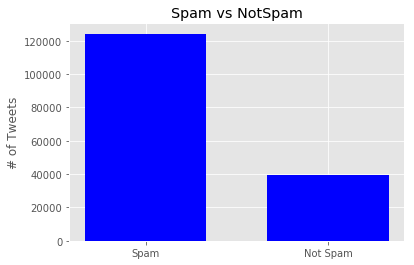

In [21]:
import matplotlib.pyplot as plt

y = [len(df_spam),len(df)]
x = [0,1]
x_label=['Spam','Not Spam']
width = 1/1.5
plt.bar(x,y, width, color="blue",align='center')
plt.xticks(range(len(x)),x_label)
plt.ylabel("# of Tweets")
plt.title("Spam vs NotSpam")
fig = plt.gcf()

In [26]:
print df.loc[df['user.screen_name']=='BestDVDsB']['text']

2016-12-25 09:10:53    X-Men: Apocalypse (Blu-ray/DVD 2016 2-Disc w/S...
2016-12-25 12:20:26    PET SHOP BOYS PERFORMANCE / SOMEWHERE  / MONTA...
2016-12-25 17:01:23    The Lady in White (Blu-ray Disc, 2016, 2-Disc ...
2016-12-24 07:27:20    The Good Doctor Do No Harm Blu-Ray Disc. Magno...
2016-12-25 16:01:21    FAST FIVE (BLU-RAY / DVD, 2011, 2 Discs) Vin D...
2016-12-25 17:26:06    Drag Me To Hell (Blu-ray Disc, 2012) https://t...
2016-12-25 17:17:14    The Divergent Series:Allegiant (*4K*Blu-ray+DV...
2016-12-25 06:52:20    Undying Dreams Blu-ray https://t.co/Tt0RWPe2pk...
2016-12-24 09:17:36    MARC BOLAN &amp; T.REX-BORN TO BOOGIE - THE MO...
2016-12-25 11:55:30    The Hunger Games + Catching Fire + Mocking Jay...
2016-12-24 18:30:41    Gravity (Blu-ray Disc, 2013) **BRAND NEW FACTO...
2016-12-25 06:40:28    Sherlock Holmes (Blu-ray Disc, 2010) https://t...
2016-12-24 12:57:40    Imax: Under the Sea (3D/Blu-ray Disc, 2010) ht...
2016-12-25 06:40:14    Unbroken (Blu-ray/DVD, 2015,

# Plotting User Location

In [19]:
locToGeo=dict()
with open("/home/uppu/locationToGeoMapping.txt") as f:
    for line in f:
        temp= line.split(":")
        key = temp[0]
        if len(temp)>1 and len(temp)==2:
            locToGeo[key] = temp[1].strip('\n')
print len(locToGeo)

3556


In [23]:
asking="hello! what's your name?"
out = "".join(c for c in asking if c not in ('!','.',':'))
print out

hello what's your name?


# Plotting using User-Co ordinates and User Location

(28250, 8299)


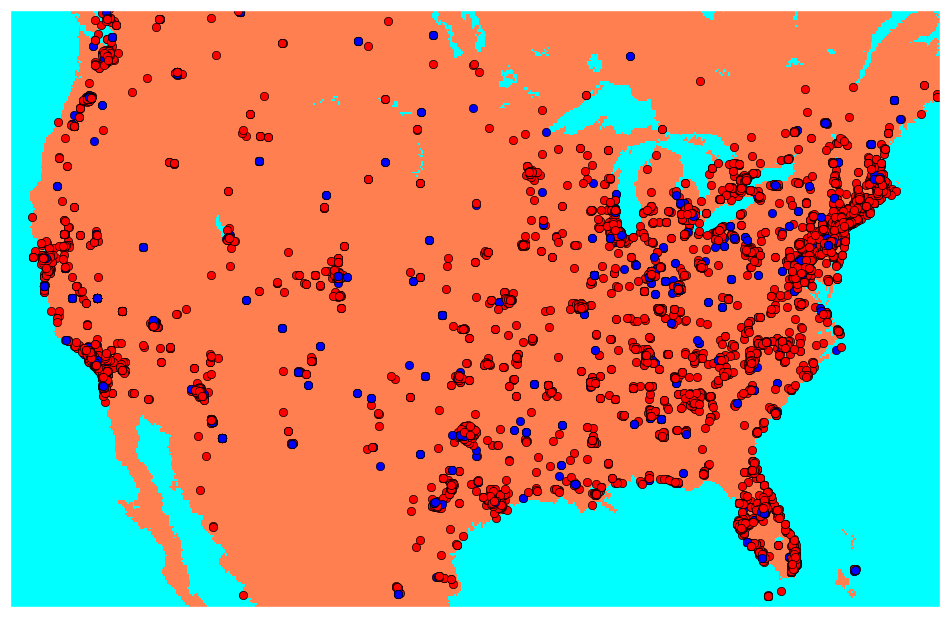

In [20]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt 
import math


plt.figure(figsize=(12,60))
map = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,projection='lcc',lat_1=32,lat_2=45,lon_0=-95)

map.drawlsmask(land_color='coral',ocean_color='aqua',lakes=True)

coordinates_count=0
location_count=0

for index,row in df.iterrows():
    if row["coordinates"]:
        #print row
        longitude,latitude=map(float(row['coordinates'][0]),float(row['coordinates'][1]))
        map.plot(longitude,latitude,marker='o',color='Red')
        coordinates_count+=1
    elif row["user.location"]:
        #print "Loc:",row["user.location"],"Coor",row["coordinates"]
        if row["user.location"] in locToGeo:
            i=locToGeo[row["user.location"]].split(',')
            if float(i[0])!='' and float(i[1])!='':
                #print i[0],i[1]
                longitude,latitude=map(float(i[0]),float(i[1]))
                map.plot(longitude,latitude,marker='o',color='Blue')
                location_count+=1

print (coordinates_count,location_count)

# Plotting based on time frame

3102460 3085663


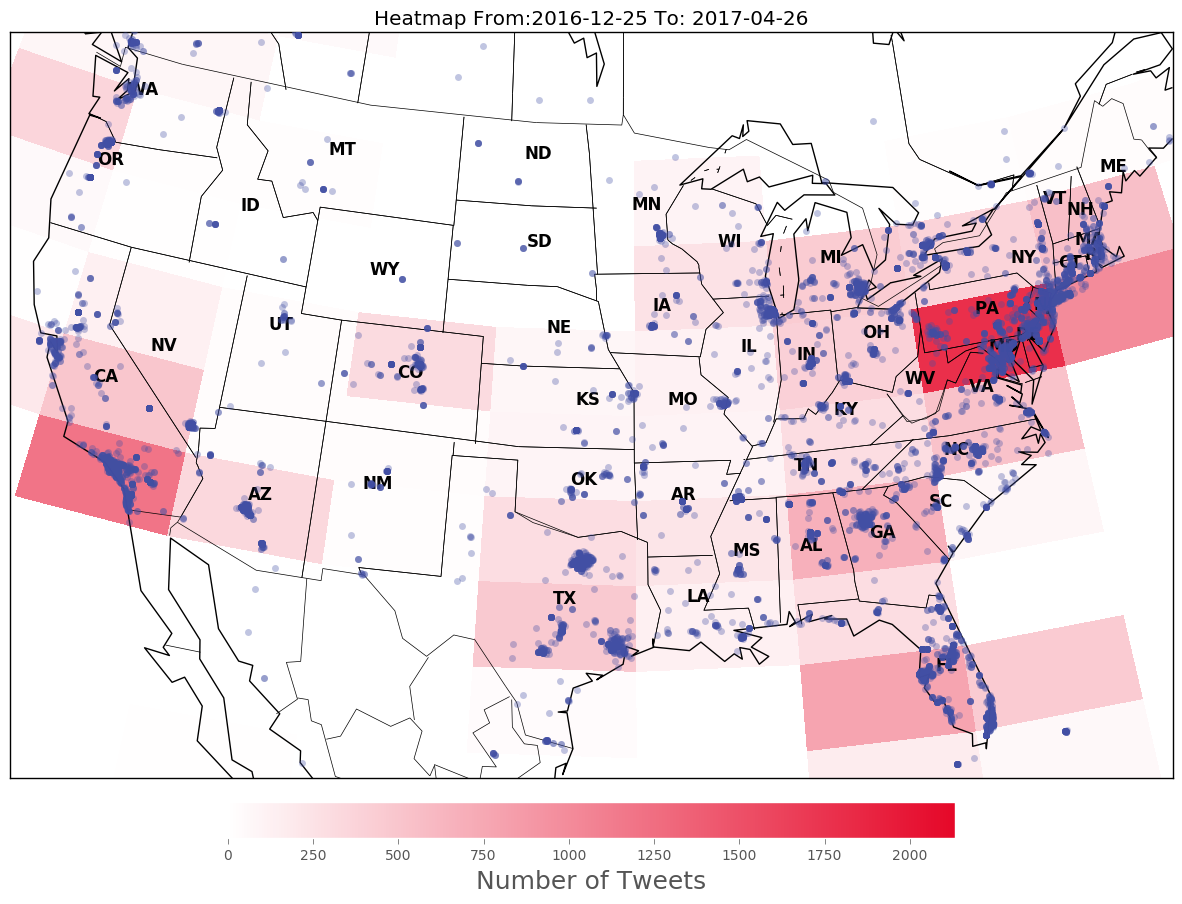

(26565, 0)


In [244]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt 
import math
import datetime
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

#Define TimeFrame
start=datetime.date(2016,12,25)
#end=start+datetime.timedelta(days=13)
end=datetime.date.today()

#Plot the basic US map
plt.figure(figsize=(12,60))
map = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,projection='lcc',lat_1=32,lat_2=45,lon_0=-95)

#map.drawlsmask(land_color='coral',ocean_color='aqua',lakes=True)
map.drawstates()
map.drawcoastlines()
map.drawcountries()
map.drawmapboundary()
#Create the mask
mask = (df['created_at'] > start) & (df['created_at'] <= end)
print len(mask),len(df.loc[mask]['coordinates'])
coordinates_count=0
location_count=0

lats, lons = [], []

#Plot point from coordinates in red
for i in df.loc[mask]['coordinates']:
    if i:
        longitude,latitude=map(float(i[0]),float(i[1]))
        lats.append(float(i[1]))
        lons.append(float(i[0]))
        #map.plot(longitude,latitude,marker='o',color='Red')
        coordinates_count+=1
    

#Plot point from location in blue
for i in df.loc[mask]['user.location']:
    #print i
    if i:
        #print i
        if row["user.location"] in locToGeo:
            i=locToGeo[row["user.location"]].split(',')
            if float(i[0])!='' and float(i[1])!='':
                longitude,latitude=map(float(i[0]),float(i[1]))
                map.plot(longitude,latitude,marker='o',color='Blue')
                location_count+=1

db = 1 # bin padding
lon_bins = np.linspace(min(lons)-db, max(lons)+db, 50+1) # 10 bins
lat_bins = np.linspace(min(lats)-db, max(lats)+db, 53+1) # 13 bins
    
density, _, _ = np.histogram2d(lats, lons, [lat_bins, lon_bins])

# Turn the lon/lat of the bins into 2 dimensional arrays ready
# for conversion into projected coordinates
lon_bins_2d, lat_bins_2d = np.meshgrid(lon_bins, lat_bins)

# convert the bin mesh to map coordinates:
xs, ys = map(lon_bins_2d, lat_bins_2d) # will be plotted using pcolormesh
# ######################################################################

# define custom colormap, white -> nicered, #E6072A = RGB(0.9,0.03,0.16)
cdict = {'red':  ( (0.0,  1.0,  1.0),
                   (1.0,  0.9,  1.0) ),
         'green':( (0.0,  1.0,  1.0),
                   (1.0,  0.03, 0.0) ),
         'blue': ( (0.0,  1.0,  1.0),
                   (1.0,  0.16, 0.0) ) }
custom_map = LinearSegmentedColormap('custom_map', cdict)
plt.register_cmap(cmap=custom_map)


# add histogram squares and a corresponding colorbar to the map:
plt.pcolormesh(xs, ys, density, cmap="custom_map")

cbar = plt.colorbar(orientation='horizontal', shrink=0.625, aspect=20, fraction=0.2,pad=0.02)
cbar.set_label('Number of Tweets',size=18)

# translucent blue scatter plot of epicenters above histogram:    
x,y = map(lons, lats)
map.plot(x, y, 'o', markersize=5,zorder=6, markerfacecolor='#424FA4',markeredgecolor="none", alpha=0.33)

#map.drawmapscale(-119-6, 37-7.2, -119-6, 37-7.2, 500, barstyle='fancy', yoffset=20000)

# make image bigger:
plt.gcf().set_size_inches(15,15)

states={'AL':(32.7990,-86.8073),'AR':(34.9513,-92.3809),'AZ':(33.7712,-111.3877),'CA':(36.778259,-119.417931),'CO':(39.0646,-105.3272),
       'CT':(41.5834,-72.7622),'DE':(39.3498,-75.5148),'FL':(27.8333,-81.7170),'GA':(32.9866,-83.6487),
       'IA':(42.0046,-93.2140),'ID':(44.2394,-114.5103),'IL':(40.3363,-89.0022),'IN':(39.8647,-86.2604),'KS':(38.5111,-96.8005),
       'KY':(37.6690,-84.6514),'LA':(31.1801,-91.8749),'MA':(42.2373,-71.5314),'MD':(39.0724,-76.7902),'ME':(44.6074,-69.3977),
       'MI':(43.3504,-84.5603),'MN':(45.7326,-93.9196),'MO':(38.4623,-92.3020),'MS':(32.7673,-89.6812),'MT':(46.9048,-110.3261),
       'NC':(35.6411,-79.8431),'ND':(47.5362,-99.7930),'NE':(41.1289,-98.2883),'NH':(43.4108,-71.5653),'NJ':(40.3140,-74.5089),
       'NM':(34.8375,-106.2371),'NV':(38.4199,-117.1219),'NY':(42.1497,-74.9384),'OH':(40.3736,-82.7755),'OK':(35.5376,-96.9247),
       'OR':(44.5672,-122.1269),'PA':(40.5773,-77.2640),'RI':(41.6772,-71.5101),'SC':(33.8191,-80.9066),'SD':(44.2853,-99.4632),
       'TN':(35.7449,-86.7489),'TX':(31.1060,-97.6475),'UT':(40.1135,-111.8535),'VA':(37.7680,-78.2057),'VT':(44.0407,-72.7093),
       'WA':(47.3917,-121.5708),'WI':(44.2563,-89.6385),'WV':(38.4680,-80.9696),'WY':(42.7475,-107.2085)}
for key in states.keys():
    x,y=map(states[key][1], states[key][0])
    plt.text(x, y, key,fontsize=12,fontweight='bold',ha='center',va='bottom',color='k')
#x, y = map(-119.417931, 36.778259)
plt.title('Heatmap From:'+str(start)+' To: '+str(end))
plt.show()
print (coordinates_count,location_count)

In [2]:
from geopy.geocoders import Nominatim
geolocator = Nominatim()
location = geolocator.reverse("23,-119")
print location.raw
print len(df['coordinates'])

{u'error': u'Unable to geocode'}


NameError: name 'df' is not defined

In [306]:
import requests
r=requests.get("http://nominatim.openstreetmap.org/reverse?format=json&lat=59&lon=10&zoom=18&addressdetails=1")
print r.text


ConnectionError: HTTPConnectionPool(host='nominatim.openstreetmap.org', port=80): Max retries exceeded with url: /reverse?format=json&lat=59&lon=10&zoom=18&addressdetails=1 (Caused by NewConnectionError('<requests.packages.urllib3.connection.HTTPConnection object at 0x7fd8b7490550>: Failed to establish a new connection: [Errno 101] Network is unreachable',))

In [302]:
fopen = open("/home/uppu/location1.txt","a")
count=0
count_usa=0
for col in df['coordinates'][:50000]:
    if col!=None:
        count+=1
        longitude,latitude=float(col[0]),float(col[1])
        if latitude<50 and latitude >=22 and longitude<-63 and longitude>-129:
            count_usa+=1
            point=str(latitude)+","+str(longitude)
            try:
                location = geolocator.reverse(point)
                #if location.raw!=" " and location.raw['address'] is not None and location.raw['address']['country']=="United States of America" and location.raw['address']['state'] in location.raw['address'].keys():
                fopen.write(str(point)+":"+str(location.raw)+"\n")
            except:
                print point
fopen.close()
print count,count_usa

37.36199,-79.2878999
40.6633,-73.6106
38.56566974,-90.35328778
29.96881778,-90.05556679
49.27831975,-123.11450636
40.04656266,-86.01445682
35.9931831,-78.9042969
39.31179,-76.61686
39.1348,-121.626
34.13571,-118.26332
40.65918,-73.69824
45.52,-122.682
30.22775,-97.76067
27.9591,-82.5093
42.677484,-73.84493
47.23406425,-122.47769288
39.74467755,-104.99790815
32.857891,-97.370132
37.3544,-121.969
34.07395,-118.21622
36.035984,-83.8762589
26.055,-80.1531
32.89023624,-96.48079547
27.89528556,-82.74566397
40.69416667,-73.91861111
30.8364,-83.9782
47.716568,-117.426131
40.61196114,-75.37787406
34.49982,-117.24309
40.8229593,-73.2092113
30.39052084,-97.74718078
42.342873,-88.252846
34.17025,-118.54117
43.63832,-79.41776
33.112778,-117.08046
45.53519473,-122.6258248
36.0606099,-79.85059
27.9229876,-82.2949131
42.15697,-71.06906
35.780498,-78.63911
39.351281,-75.000411
32.79778,-79.9346599
27.98157099,-82.82708699
37.67921,-97.44376
28.54105,-81.37849
25.7877,-80.2241
35.85934907,-78.70792141
3

In [243]:
for index,row in df.iterrows()[:4]:
    if row["coordinates"]:
        #print row
        longitude,latitude=map(float(row['coordinates'][0]),float(row['coordinates'][1]))
        location = geolocator.reverse(latitude, longitude)
        print location.raw
        coordinates_count+=1
    elif row["user.location"]:
        #print "Loc:",row["user.location"],"Coor",row["coordinates"]
        if row["user.location"] in locToGeo:
            i=locToGeo[row["user.location"]].split(',')
            
            
            if float(i[0])!='' and float(i[1])!='':
                #print i[0],i[1]
                longitude,latitude=map(float(i[0]),float(i[1]))
                map.plot(longitude,latitude,marker='o',color='Blue')
                location_count+=1

print (coordinates_count,location_count)

TypeError: 'generator' object has no attribute '__getitem__'

# Generating the Location To Geo-Encoding Mapping

In [ ]:
locToGeo=dict()
with open("/home/uppu/locationToGeoMapping.txt") as f:
    for line in f:
        temp= line.split(":")
        #print temp
        key = temp[0].rstrip('?:!.,;')
        #print key,temp[1]
        locToGeo[key] = temp[1].strip('\n')
       

In [ ]:
print len(locToGeo)

In [ ]:
from collections import Counter
common_locations=dict(Counter(df['user.location']))
print len(common_locations)

In [28]:
from geopy.geocoders import Nominatim
def is_ascii(s):
    return all(ord(c) < 128 for c in s)

geolocator = Nominatim()
fopen = open("/home/uppu/locationToGeoMapping.txt","a")
fopen_noMapping=open("/home/uppu/locationToNoGeoMapping.txt","a")
for key,val in sorted(common_locations.items(),key=itemgetter(1),reverse=True)[:10]:
    print key
    try:
        key=key.encode('ascii')
        if type(key)==str and is_ascii(key): #and key not in locToGeo.keys():
            location = geolocator.geocode(key)
            print(location)
            if location is not None and location.latitude!="":
                #fopen.write(str(key.lower())+":"+str(location.longitude)+","+str(location.latitude)+"\n")
                print key,location
            if location is None:
                #fopen_noMapping.write(str(key.lower())+":"+str(val)+"\n")
                print location,key
    except:
        print ("Err")
fopen.close()
fopen_noMapping.close()   

False
Err
United States
Err
Canada
Err
Los Angeles, CA
Err
New York, USA
Err
United Kingdom
Err
Worldwide
Err
USA
Err
California, USA
Err
US
Err


In [1]:
print "hello"

hello


# Bi Weekly Comparison on Hashtags

In [72]:
hashTags={}
def is_ascii(s):
    return all(ord(c) < 128 for c in s)

import datetime
start=datetime.date(2016,12,25)
end=start+datetime.timedelta(days=13)
now=datetime.date.today()

while now>end:
    print start, end
    hashTags={}
    mask = (df['created_at'] > start) & (df['created_at'] <= end)
#print(df.loc[mask]['entities.hashtags'])
    for i in df.loc[mask]['entities.hashtags']:
        if type(i)==list:
            for j in i:
                try:
                    k=j.encode('ascii').lower()
                    if is_ascii(k):
                        if k in hashTags.keys():
                            hashTags[k]=hashTags[k]+1
                        else:
                            hashTags[k]=1
                except:
                    continue
                
    print(len(hashTags))
    start=end+datetime.timedelta(days=1)
    end=start+datetime.timedelta(days=13)

    for key,val in sorted(hashTags.items(),key=itemgetter(1),reverse=True)[:100]:
        print key,val



2016-12-25 2017-01-07
25093
vape 5980
vaping 5019
starprince_desireftblu 2352
quotes 2087
cigar 1846
fact 1738
ecigs 1632
tobacco 1495
vapelife 1320
ecig 1285
mustweed 1197
marijuana 1033
vapefam 1006
stocks 926
ejuice 874
cigarette 855
airquality 842
knowyourair 841
vapenation 841
vapor 795
blu 789
smoking 725
cannabis 713
eliquid 690
nicotine 688
swaptober 679
stoptober 677
cigarettes 663
cigars 663
how 662
vapers 600
vapeporn 583
vapingsaveslives 581
vapeon 567
ecigarettes 558
ivapeivote 554
vaper 448
what 429
mplusplaces 417
quitsmoking 403
t 403
tech 392
vaporizer 384
vapegiveaway 382
vapecommunity 381
ecigclickawards2016 370
health 346
wupplesvape 341
vapelyfe 322
ces2017 322
london 321
duke 304
smoke 304
bluedevils 299
delhi 297
agra 284
e 278
amazongiveaway 277
ecigarette 276
followme 275
vapes 266
gambling 265
smokingfetish 263
tapxrc 254
vintage 243
notblowingsmoke 242
happynewyear 240
best 236
the 235
weed 232
videomtv2016 226
lungcancer 218
cigarlife 215
lungdisease 208
liv

In [115]:
import datetime
start=datetime.date(2016,12,25)
end=start+datetime.timedelta(days=13)
now=datetime.date.today()
while now>end:
    print start, end
    start=end+datetime.timedelta(days=1)
    end=start+datetime.timedelta(days=13)

2016-12-25 2017-01-07
2017-01-08 2017-01-21
2017-01-22 2017-02-04
2017-02-05 2017-02-18
2017-02-19 2017-03-04
2017-03-05 2017-03-18
2017-03-19 2017-04-01


# Bot or Not 

In [23]:
from collections import Counter

fopen=file("/home/uppu/usernames.txt","w")

usernames=dict(Counter(df['user.screen_name']))
#fopen.write(str(sorted(usernames.items(),key=itemgetter(1),reverse=True))+"\n")
for key,val in sorted(usernames.items(),key=itemgetter(1),reverse=True):
    #print key,val
    fopen.write(str(key)+":"+str(val)+"\n")
fopen.close()

In [27]:
print len(usernames)




884493


In [198]:
import botornot
import time
from collections import Counter
twitter_app_auth6 = {
    'consumer_key': 'NGcirU5eEiayH7MY6dQBmDD3L',
    'consumer_secret': 'zRriXHbEyYVUJzUIcXRuRnH8pbvpzowANqTCRB7YkNh2h05Cru',
    'access_token': '2441022690-Hq9dXkkVXiLiqk9pByuwEmRDyN5jTtfZwqxqiTZ',
    'access_token_secret': 'yGlyKKqLSI7aNzbx1KwH13hXYUpoepfpHjUHNegoLTlEp',
  }
twitter_app_auth5 = {
    'consumer_key': 'PemEXwGoIfzWJTt3aHWgdMxFm',
    'consumer_secret': 'hZmOvO5smssgMYZQayZRGFP5SdwxgDx69Ob88F9qQ7678LVC3c',
    'access_token': '2441022690-J3s9A3rugByY8KrOq2LdtC1k7bcG6tcLyzpOYvE',
    'access_token_secret': 'jjdULWrYNdleBuSVQDEkiqb7szwJE7SiXwIpFiO7mrrMy',
  }
twitter_app_auth4 = {
    'consumer_key': 'VN6ewId8QuerLuUiFIxsj8vrO',
    'consumer_secret': 'f7wX2yAQuuHE0TLxGz7sPs8N0i7Bw1YGThT8XEP9EEshKgsbb7',
    'access_token': '2441022690-Tak8PHkXNUjxWLee31YLJOJVCUG182gMZyVy7ky',
    'access_token_secret': 'xFM4q6pkkYUhlZdVwZcte1CTOcuZlTROkNkCgshMXp96Y',
  }


fopen=file("/home/uppu/botOrNotResults.txt","a")
count=0
usernames=dict(Counter(df['user.screen_name']))
print(len(usernames))

for key,val in sorted(usernames.items(),key=itemgetter(1),reverse=True):
    bon = botornot.BotOrNot(**twitter_app_auth4)
    result = bon.check_account('@'+str(key))
    fopen.write(str(result)+"\n")
    print(result)
    count+=1
    if count==48:
        time.sleep(918)
        count=0
fopen.close()

115345
{u'meta': {u'user_id': u'778658960198868992', u'screen_name': u'BestDVDsB'}, u'score': 0.39, u'categories': {u'content_classification': 0.61, u'temporal_classification': 0.71, u'network_classification': 0.8402460533482703, u'friend_classification': 0.7931471336512232, u'sentiment_classification': 0.15, u'languageagnostic_classification': 0.37, u'user_classification': 0.53}}
{u'meta': {u'user_id': u'774105028311134208', u'screen_name': u'TerrificDVDs'}, u'score': 0.32, u'categories': {u'content_classification': 0.74, u'temporal_classification': 0.74, u'network_classification': 0.8402460533482703, u'friend_classification': 0.7931471336512232, u'sentiment_classification': 0.33, u'languageagnostic_classification': 0.29, u'user_classification': 0.54}}
{u'meta': {u'user_id': u'776929295700590592', u'screen_name': u'SpecialDVDs'}, u'score': 0.43, u'categories': {u'content_classification': 0.58, u'temporal_classification': 0.6833333333333335, u'network_classification': 0.840246053348270

TweepError: Not authorized.

# Hash tags Concept Clusters

In [43]:
#Collecting hashtags based on start and end date

import datetime
hashTags=[]
nodes=[]
edges=[]
fileNodes = open("../Home/nodes.csv","w")
fileEdges = open("../Home/edges.csv","w")
def is_ascii(s):
    return bool(re.match(r'[\x00-\x7F]+$', s))

start=datetime.date(2017,1,8)
end=start+datetime.timedelta(days=13)
now=datetime.date.today()
count=0
while now>end:
    if count==1:
        break
    count+=1
    print start, end
    hashTags=[]
    nodes=[]
    edges=[]
    
    mask = (df['created_at'] > start) & (df['created_at'] <= end)
    #print(df.loc[mask]['entities.hashtags'])
    for i in df.loc[mask]['entities.hashtags']:
        if type(i)==list:
            hashTags.append(i)
    print(len(hashTags))
    start=end+datetime.timedelta(days=1)
    end=start+datetime.timedelta(days=13)
    
    for i in hashTags:
        for j in i:
            if j not in nodes:
                nodes.append(j)
            for k in i[i.index(j)+1:]:
                if k not in nodes:
                    nodes.append(k)
                edges.append([nodes.index(j),nodes.index(k)])
    #print nodes,edges
    for i in nodes:
        if is_ascii(i):
            fileNodes.write(str(nodes.index(i))+","+str(i.lower())+"\n")
    fileNodes.write("\n"+"**************************"+"\n")
    
    for i in edges:
        fileEdges.write(str(i[0])+","+str(i[1])+"\n")
    fileEdges.write("\n"+"**************************"+"\n")
    
fileNodes.close()
fileEdges.close()

2017-01-08 2017-01-21
0


In [44]:
hashTags=[]
for i in df['entities.hashtags']:
    if type(i)==list:
        hashTags.append(i)
print(len(hashTags))

7629


In [ ]:
print 

In [31]:
nodes=[]
edges=[]
fileNodes = open("/home/uppu/nodes.csv","w")
fileEdges = open("/home/uppu/edges.csv","w")
def is_ascii(s):
    return bool(re.match(r'[\x00-\x7F]+$', s))

for i in hashTags:
    #print i
    for j in i:
        if j not in nodes:
            nodes.append(j)
        for k in i[i.index(j)+1:]:
            if k not in nodes:
                nodes.append(k)
            edges.append([nodes.index(j),nodes.index(k)])
#print nodes,edges
fileNodes.write("Id"+","+"Label"+"\n")
for i in nodes:
    if is_ascii(i):
        fileNodes.write(str(nodes.index(i))+","+str(i.lower())+"\n")
fileNodes.close()
fileEdges.write("Source"+","+"Target"+","+"Type"+"\n")
for i in edges:
    fileEdges.write(str(i[0])+","+str(i[1])+","+"Undirected"+"\n")
fileEdges.close()

In [41]:
#Formating the file
f1 = open("/home/uppu/edges1.csv","w")
f2=open("/home/uppu/edges.csv","r")
with f2 as f:
    content = f.readlines()
print len(content),type(content)
f1.write("Source"+","+"Target"+","+"Type"+"\n")
for i in content:
    f1.write(i.strip()+","+"Undirected"+"\n")
f1.close()

1245283 <type 'list'>


In [44]:
#Formatting the nodes File
f1 = open("/home/uppu/nodes1.csv","w")
f2=open("/home/uppu/nodes.csv","r")
with f2 as f:
    content = f.readlines()
print len(content),type(content)
f1.write("Id"+","+"Label"+"\n")
for i in content:
    f1.write(i)
f1.close()

119964 <type 'list'>


In [39]:
hashTags=[]
nodes=[]
edges=[]
fileNodes = open("/home/uppu/nodes.csv","w")
fileEdges = open("/home/uppu/edges.csv","w")
def is_ascii(s):
    return bool(re.match(r'[\x00-\x7F]+$', s))

start=datetime.date(2017,3,5)
end=start+datetime.timedelta(days=13)
now=datetime.date.today()
count=0
while now>end:
    if count==1:
        break
    count+=1
    print start, end
    hashTags=[]
    nodes=[]
    edges=[]
    
    mask = (df['created_at'] > start) & (df['created_at'] <= end)
    #print(df.loc[mask]['entities.hashtags'])
    for i in df.loc[mask]['entities.hashtags']:
        if type(i)==list:
            hashTags.append(i)
    print(len(hashTags))
    start=end+datetime.timedelta(days=1)
    end=start+datetime.timedelta(days=13)
    
    for i in hashTags:
        for j in i:
            if j not in nodes:
                nodes.append(j)
            for k in i[i.index(j)+1:]:
                if k not in nodes:
                    nodes.append(k)
                edges.append([nodes.index(j),nodes.index(k)])
    #print nodes,edges
    fileNodes.write("Id"+","+"Label"+"\n")
    for i in nodes:
        if is_ascii(i):
            fileNodes.write(str(nodes.index(i))+","+str(i.lower())+"\n")
    #fileNodes.write("\n"+"**************************"+"\n")
    
    fileEdges.write("Source"+","+"Target"+","+"Type"+"\n")
    for i in edges:
        fileEdges.write(str(i[0])+","+str(i[1])+","+"Undirected"+"\n")
    #fileEdges.write("\n"+"**************************"+"\n")
    
fileNodes.close()
fileEdges.close()

2017-03-05 2017-03-18
75000


In [35]:
start=datetime.date(2016,12,25)
end=start+datetime.timedelta(days=13)
now=datetime.date.today()
while now>end:
    print start, end
    start=end+datetime.timedelta(days=1)
    end=start+datetime.timedelta(days=13)
    

2016-12-25 2017-01-07
2017-01-08 2017-01-21
2017-01-22 2017-02-04
2017-02-05 2017-02-18
2017-02-19 2017-03-04
2017-03-05 2017-03-18


In [99]:
fopen= open("/home/uppu/botResults.txt","r")
count=1
with fopen as f:
    for line in f:
        #print line[:line.index('(')],line[line.index('screen_name')+16:line.index("}")-1]
        if line[:line.index('(')]!=line[line.index('screen_name')+16:line.index("}")-1]:
            print "'"+line[:line.index('(')]+"',"
            count+=1
            if count==1000:
                break
print count

'lillianduhones',
'wiseanus1',
'nuclearphospho2',
'bittopper_com',
'maddeningspeci2',
'resultminutes1',
'halogensnotati2',
'cartloadsynony1',
'placesvote1',
'fashionsarsoni2',
'swainresolves1',
'asteroidleaden1',
'sneersternway1',
'mathphoto1',
'blisterhumdrum1',
'neglectedquart2',
'javareproduce1',
'retrievedhappy1',
'limbicrunning1',
'greenhousebutc2',
'democracyfloss1',
'obeysyntaxis',
'castratereflec',
'cosecdisorder',
'hingetransform',
'Adamhernandz927',
'Teadso__Fuokje',
'ltsAquaa',
'rincon_sports',
'Favstar_Bot',
'DiabetesNews323',
'pebbkenklessba1',
'_PerformingArt_',
'telefonsex24com',
'BlStone68',
'NewHealthItem',
'pondokvape',
'VapinGreek',
'flutter4mebutt1',
'fscarfe',
'AshliGillespie',
'IncredibleHealT',
'Movies_Sales',
'philusb',
'alzubrahabeeba',
'BluRayNewsRSS',
'gbf_hospital',
'TheCigarHumidor',
'StunnningCellP',
'Kimberely_Mcgra',
'TerrificSportC',
'harleypartsman7',
'UltraHDBluray',
'BonnieMcKeeGodd',
'eJuiceMonkeys',
'CigarChairman',
'VapingAlliance',
'thedigitalvib

In [36]:
import botornot
twitter_app_auth6 = {
    'consumer_key': 'NGcirU5eEiayH7MY6dQBmDD3L',
    'consumer_secret': 'zRriXHbEyYVUJzUIcXRuRnH8pbvpzowANqTCRB7YkNh2h05Cru',
    'access_token': '2441022690-Hq9dXkkVXiLiqk9pByuwEmRDyN5jTtfZwqxqiTZ',
    'access_token_secret': 'yGlyKKqLSI7aNzbx1KwH13hXYUpoepfpHjUHNegoLTlEp',
  }
bon = botornot.BotOrNot(**twitter_app_auth6)
result=""
try:
    result = bon.check_account('@'+str("pondokvape"))
    print "hey",result
except:
    print "cool",result
if result=="":
    print "yeo"

ImportError: No module named botornot

In [63]:
#Merging Files botResults.txt — botResults3.txt
fopen= open("/home/uppu/botOrNotResults.txt","a")
fopen1=open("/home/uppu/botResults.txt","r")
fopen3=open("/home/uppu/botResults3.txt","r")
with fopen1 as f:
    content1 = f.readlines()
with fopen3 as f:
    content3 = f.readlines()
print len(content1),len(content3)
count=0
temp=0
for i in content1:
    temp1=i[:i.index('(')]
    temp2=i[i.index('screen_name')+16:i.index('}')-1]
    if temp1==temp2:
        #print temp1, temp2
        #print i
        fopen.write(i)
    else:
        temp+=1
        #print count
        for j in content3[count:]:
            temp3=j[:j.index('(')]
            temp4=j[j.index(':')+1:]
            temp5=j[j.index('(')+1:j.index(')')]
            #print j
            if temp3==temp1:
                #print temp1,temp3
                fopen.write(j)
                count+=1
            #else:
             #   print temp3, temp1
#for i in content3:
 #   fopen.write(i)
print temp 
fopen.close()
fopen1.close()
fopen3.close()

10000 5762
5762


In [76]:
#Merging Files botResults1.txt — botResults4.txt
fopen= open("/home/uppu/botOrNotResults1.txt","w")
fopen1=open("/home/uppu/botResults1.txt","r")
fopen3=open("/home/uppu/botResults4.txt","r")
with fopen1 as f:
    content1 = f.readlines()
with fopen3 as f:
    content3 = f.readlines()
print len(content1),len(content3)
count=0
temp=0
for i in content1:
    temp1=i[:i.index('(')]
    temp2=i[i.index(':')+1:]
    temp3=i[i.index('(')+1:i.index(')')]
    if temp2!="\n":
        #print temp1, temp2
        #print i
        fopen.write(i)
    else:
        temp+=1
        #print i
        for j in content3[count:]:
            temp3=j[:j.index('(')]
            temp4=j[j.index(':')+1:]
            temp5=j[j.index('(')+1:j.index(')')]
            #print j
            if temp3==temp1:
                #print temp1,temp3
                fopen.write(j)
                count+=1
                break
            #else:
             #   print temp3, temp1
#for i in content3:
 #   fopen.write(i)
print temp 
fopen.close()
fopen1.close()
fopen3.close()

11632 7016
7016


In [72]:
#Number of 0 results for Bot Or Not
# 4671,1781
fopen=file("/home/uppu/botOrNotResults.txt","r")
count=0
with fopen as f:
    content = f.readlines()
#print content[:10]
for i in content:
    temp1=i[:i.index('(')]
    temp2=i[i.index(':')+1:]
    temp3=i[i.index('(')+1:i.index(')')]
    #print temp1,temp3,temp2,temp3
    if temp2=="\n":
        count+=1
fopen.close()
print count

2781


In [102]:
fopen=file("/home/uppu/botResults.txt","r")
with fopen as f:
    content=f.readlines()
print len(content)
score=[]
count=0
for i in content:
    try:
        temp=i[i.index('score'):]
        s=temp[temp.index('score')+8:temp.index(',')]
        score.append(float(s))
    except:
        count+=1
f.close()
print len(score),count

20000
13219 6781


In [228]:
#Counting the numbers on other files
fopen=file("/home/uppu/botResults9.txt","r")
with fopen as f:
    content=f.readlines()
print len(content)
score=[]
no_ratings_count=0
for i in content:
    try:
        temp=i[i.index('score'):]
        s=temp[temp.index('score')+8:temp.index(',')]
        score.append(float(s))
    except:
        no_ratings_count+=1
f.close()
print len(score),no_ratings_count

7045
2381 4664


In [68]:
#Counting the numbers on other files
fopen=file("/home/uppu/botResults7.txt","r")
with fopen as f:
    content=f.readlines()
print len(content)
score=[]
count=0
for i in content:
    try:
        temp=i[i.index('score'):]
        s=temp[temp.index('score')+8:temp.index(',')]
        score.append(float(s))
    except:
        count+=1
f.close()
print len(score),count

71200
24710 46490


In [105]:
print len(score),score[:10]

13219 [0.4, 0.35, 0.44, 0.38, 0.38, 0.34, 0.42, 0.46, 0.52, 0.67]


In [1]:
import numpy as np
import scipy.stats as stats
import pylab as pl

h = sorted(score)  #sorted

fit = stats.norm.pdf(h, np.mean(h), np.std(h))  #this is a fitting indeed

pl.plot(h,fit,'-o')

pl.hist(h,normed=True)      #draw histogra

pl.show()             

NameError: name 'score' is not defined

In [39]:
#Visualizing in histogram
#fopen=file("/home/uppu/botResults.txt","r")
fopen=file("/Users/suppu/Desktop/Dr/Home/botResults.txt","r")
with fopen as f:
    content=f.readlines()
print len(content)
score=dict()
count=0
for i in content:
    try:
        temp=i[i.index('score'):]
        s=temp[temp.index('score')+8:temp.index(',')]
        #print s
        if float(s)>0.9:
            print i
        if float(s) not in score.keys():
            score[float(s)]=1
        else:
            score[float(s)]=score[float(s)]+1
    except:
        #print i
        count+=1
f.close()
print len(score),count
sum=0
for key,val in score.items():
    sum+=val
print sum

20000
QuitSmokHappy(186) :{u'meta': {u'user_id': u'706494627080179712', u'screen_name': u'QuitSmokHappy'}, u'score': 0.91, u'categories': {u'content_classification': 0.76, u'temporal_classification': 0.78, u'network_classification': 0.765439788731825, u'friend_classification': 0.7931471336512232, u'sentiment_classification': 0.84, u'languageagnostic_classification': 0.92, u'user_classification': 0.98}}

CableDepot(129) :{u'meta': {u'user_id': u'2620891035', u'screen_name': u'CableDepot'}, u'score': 0.91, u'categories': {u'content_classification': 0.71, u'temporal_classification': 0.51, u'network_classification': 0.8402460533482703, u'friend_classification': 0.7931471336512232, u'sentiment_classification': 0.86, u'languageagnostic_classification': 0.84, u'user_classification': 0.97}}

HoundoomBot(127) :{u'meta': {u'user_id': u'1447742743', u'screen_name': u'HoundoomBot'}, u'score': 0.9066666666666667, u'categories': {u'content_classification': 0.8633333333333334, u'temporal_classificati

In [33]:
print content[:2]

["BestDVDsB(17040) :{u'meta': {u'user_id': u'778658960198868992', u'screen_name': u'BestDVDsB'}, u'score': 0.4, u'categories': {u'content_classification': 0.67, u'temporal_classification': 0.64, u'network_classification': 0.8402460533482703, u'friend_classification': 0.7931471336512232, u'sentiment_classification': 0.68, u'languageagnostic_classification': 0.33, u'user_classification': 0.63}}\n", "OutstandingDVD(16746) :{u'meta': {u'user_id': u'776445467433459714', u'screen_name': u'OutstandingDVD'}, u'score': 0.35, u'categories': {u'content_classification': 0.62, u'temporal_classification': 0.65, u'network_classification': 0.8402460533482703, u'friend_classification': 0.7931471336512232, u'sentiment_classification': 0.28, u'languageagnostic_classification': 0.46, u'user_classification': 0.51}}\n"]


In [37]:
#print score
score_dict=dict()
i=0
#Initilaizing the dictionary
while(i<=1):
    temp=round(i,1)
    score_dict[temp]=0
    i=i+0.1
print score_dict
#score_dict=sorted(score_dict.items())
i=0
for key,val in score.items():
    if key>=0.9:
        score_dict[0.9]+=val
    elif key>=0.8:
        score_dict[0.8]+=val
    elif key>=0.7:
        score_dict[0.7]+=val
    elif key>=0.6:
        score_dict[0.6]+=val
    elif key>=0.5:
        score_dict[0.5]+=val
    elif key>=0.4:
        score_dict[0.4]+=val
    elif key>=0.3:
        score_dict[0.3]+=val
    elif key>=0.2:
        score_dict[0.2]+=val
    elif key>=0.1:
        score_dict[0.1]+=val
    elif key>=0.0:
        score_dict[0.0]+=val
print sorted(score_dict.items())

sum=0
for key,val in score_dict.items():
    sum+=val
print sum


{0.0: 0, 0.5: 0, 0.2: 0, 0.4: 0, 1.0: 0, 0.8: 0, 0.6: 0, 0.3: 0, 0.1: 0, 0.9: 0, 0.7: 0}
0.905 1
0.96 3
0.94 5
0.93 3
0.97 1
0.92 3
0.95 2
0.91 9
0.906666666667 1
0.9 10
[(0.0, 57), (0.1, 515), (0.2, 1407), (0.3, 2647), (0.4, 3274), (0.5, 2548), (0.6, 1507), (0.7, 901), (0.8, 325), (0.9, 38), (1.0, 0)]
13219


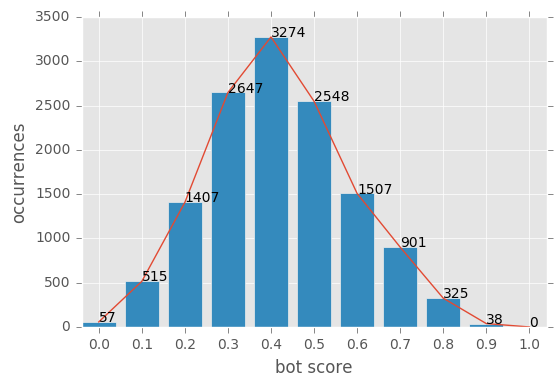

In [28]:
from matplotlib import pyplot
lists = sorted(score_dict.items())
#print lists
x, y = zip(*lists)

plt.bar(range(len(x)), y, align='center')
plt.xticks(range(len(x)), x)
#Displying line
plt.plot(range(len(x)),y)
#Displaying the values
for a,b in zip(range(len(x)), y): 
    pyplot.text(a, b, str(b))
    
plt.xlabel('bot score')
plt.ylabel('occurrences')

plt.show()

In [41]:
print df.loc[df['user.screen_name']=='QuitSmokHappy']['text']

Series([], Name: text, dtype: object)


# Concept Cluster for users >=0.6

In [212]:
fopen=file("/home/uppu/botResults.txt","r")
with fopen as f:
    content=f.readlines()
print len(content)
score=[]
spam_users=dict()
real_users=dict()
no_rating_count=0
for i in content:
    try:
        temp=i[i.index('score'):]
        s=temp[temp.index('score')+8:temp.index(',')]
        score.append(float(s))
        username=i[:i.index('(')]
        if float(s)>=0.6:
            spam_users[username]=float(s)
        else:
            real_users[username]=float(s)
    except:
        no_rating_count+=1
f.close()
print len(score),"Users with no rating",no_rating_count
print "Spam Users:",len(spam_users)
print "Real users:",len(real_users)


20000
13219 Users with no rating 6781
Spam Users: 2771
Real users: 10448
['interesting_f', 'bitcoinagile', 'thunderbluex76', 'suicidebunny_', 'GetfastInfo', 'sarung_hape', 'pulpmarkets', 'himnmedia', 'SoulmateBag', 'nwi']


In [226]:
import datetime
hashTags=[]
nodes=[]
edges=[]
fileNodes = open("/home/uppu/nodes_not_bot.csv","w")
fileEdges = open("/home/uppu/edges_not_bot.csv","w")
def is_ascii(s):
    return bool(re.match(r'[\x00-\x7F]+$', s))

start=datetime.date(2016,12,24)
end=datetime.date(2017,3,18)
count=0
for i in real_users.keys():   
    mask = (df['created_at'] > start) & (df['created_at'] <= end) & (df['user.screen_name']==i)
    #print len(mask)
    #print(df.loc[mask]['entities.hashtags'])
    for i in df.loc[mask]['entities.hashtags']:
        if type(i)==list:
            hashTags.append(i)
print(len(hashTags))
    
for i in hashTags:
    for j in i:
        if j not in nodes:
            nodes.append(j)
        for k in i[i.index(j)+1:]:
            if k not in nodes:
                nodes.append(k)
            edges.append([nodes.index(j),nodes.index(k)])
    #print nodes,edges
fileNodes.write("Id"+","+"Label"+"\n")
for i in nodes:
    if is_ascii(i):
        fileNodes.write(str(nodes.index(i))+","+str(i.lower())+"\n")
    #fileNodes.write("\n"+"**************************"+"\n")
    
fileEdges.write("Source"+","+"Target"+","+"Type"+"\n")
for i in edges:
    fileEdges.write(str(i[0])+","+str(i[1])+","+"Undirected"+"\n")
    #fileEdges.write("\n"+"**************************"+"\n")
    
fileNodes.close()
fileEdges.close()


135246


In [40]:
#Concept cluster for Spam dataset
print len(df_spam['entities.hashtags'])

5278456


In [41]:
hashTags_spam=[]
for i in df_spam['entities.hashtags']:
    if type(i)==list:
        hashTags_spam.append(i)
print(len(hashTags_spam))

1659183


In [ ]:
nodes=[]
edges=[]
fileNodes = open("/home/uppu/nodes_spam.csv","w")
fileEdges = open("/home/uppu/edges_spam.csv","w")
def is_ascii(s):
    return bool(re.match(r'[\x00-\x7F]+$', s))

for i in hashTags_spam:
    #print i
    for j in i:
        if j not in nodes:
            nodes.append(j)
        for k in i[i.index(j)+1:]:
            if k not in nodes:
                nodes.append(k)
            edges.append([nodes.index(j),nodes.index(k)])
#print nodes,edges
fileNodes.write("Id"+","+"Label"+"\n")
for i in nodes:
    if is_ascii(i):
        fileNodes.write(str(nodes.index(i))+","+str(i.lower())+"\n")
fileNodes.close()
fileEdges.write("Source"+","+"Target"+","+"Type"+"\n")
for i in edges:
    fileEdges.write(str(i[0])+","+str(i[1])+","+"Undirected"+"\n")
fileEdges.close()

In [43]:
print len(nodes)

119810


# Sentiment Analysis

In [44]:
print "hello"

hello


In [104]:
import subprocess, shlex, os

def RateSentiment(sentiString):
    ssroot = '/home/uppu/SentiStrength/'
    os.chdir(ssroot)

    #open a subprocess using shlex to get the command line string into the correct args list format
    p = subprocess.Popen(shlex.split("java -jar SentiStrength.jar stdin sentidata /home/emiliofe/SentiStrength/data/"),
                         stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    #communicate via stdin the string to be rated. Note that all spaces are replaced with +
    stdout_text, stderr_text = p.communicate(sentiString.replace(" ","+"))
    #remove the tab spacing between the positive and negative ratings. e.g. 1    -5 -> 1-5
    stdout_text = stdout_text.rstrip().replace("\t","")
    return stdout_text.split()[0], stdout_text.split()[1]

def RateSentimentText(filename):
    ssroot = '/home/emiliofe/SentiStrength/'
    os.chdir(ssroot)
    #open a subprocess using shlex to get the command line string into the correct args list format
    p = subprocess.Popen(shlex.split("java -jar SentiStrength.jar sentidata /home/emiliofe/SentiStrength/data/ input " + filename),
                         stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout_text, stderr_text = p.communicate()

    #remove the tab spacing between the positive and negative ratings. e.g. 1    -5 -> 1-5
    stdout_text = stdout_text.split()[-1]
    return stdout_text 

In [153]:
print len(df['text']), len(df['id'])

3102460 3102460


In [154]:
tweet_text_file = '/home/emiliofe/notebooks/Uppu/tweet_text.csv'
f=open(tweet_text_file,'w')

#!/usr/bin/env python
import re

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
#print(emoji_pattern.sub(r'', text)) # no emoji

count=0

def is_ascii(s):
    return all(ord(c) < 128 for c in s)

for i in df['text']:
    i=emoji_pattern.sub(r'', i)
    #i=i.encode('ascii')
    #print i
    if is_ascii(i):
        count+=1
        f.write((i+"\n").encode('utf-8'))
    else:
        #print i
        count+=1
        f.write((i+"\n").encode('utf-8'))
print count

3102460


In [155]:
D_tweets = defaultdict()
for idx in df['id']: D_tweets[idx] = dict()
print len(D_tweets)
#print D_tweets

3102460


In [156]:
text_sentiment_file = RateSentimentText(tweet_text_file)
print text_sentiment_file

/home/emiliofe/notebooks/Uppu/tweet_text3_out.txt


In [157]:
tweet_sentiment = defaultdict()

with open(text_sentiment_file, 'r') as f:
    header = f.readline()
    
    for k in D_tweets.keys(): 
        line = f.readline()
        #print line.split()
        if line!="":
            ps, ns = float(line.split()[0]), float(line.split()[1])
            pol = ps + ns
            D_tweets[k] = {'Pos':ps, 'Neg':ns, 'Pol':pol, 'Dummy':1}
    print len(D_tweets)

3102460


In [158]:
df_sentiment = pd.DataFrame.from_dict(D_tweets, orient='index')
df_sentiment = df_sentiment.astype(float)
print len(df_sentiment)

3102460


In [246]:
print df_sentiment[:10]

                    Neg  Pol  Pos  Dummy
812554480113815552 -1.0  0.0  1.0    1.0
812554481577656321 -1.0  0.0  1.0    1.0
812554492348485632 -2.0 -1.0  1.0    1.0
812554494135373824 -1.0  0.0  1.0    1.0
812554505183236096 -2.0 -1.0  1.0    1.0
812554550196498432 -1.0  0.0  1.0    1.0
812554558387929088 -1.0  3.0  4.0    1.0
812554586644881409 -1.0  0.0  1.0    1.0
812554624955809792 -1.0  1.0  2.0    1.0
812554697546481664 -4.0 -3.0  1.0    1.0


In [256]:
pos=0
neg=0
neutral=0
for i in df_sentiment['Pol']:
    if i==0:
        neutral+=1
    elif i>0:
        pos+=1
    elif i<0:
        neg+=1
print "Positive:",pos
print "Negative:",neg
print "Neutral:",neutral
print pos
print neg
print neutral


Positive: 690230
Negative: 372826
Neutral: 2039404
690230
372826
2039404


In [ ]:
l=[690230,372826,2039404]